In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
%matplotlib inline
from scipy.optimize import curve_fit
from typing import Union, Tuple, List, Dict

import sys
sys.path.append("../../../../src")

import nanonets_utils
import nanonets

plt.style.use(["science","bright"])

data_folder = "/home/j/j_mens07/bagheera/j_mens07/data/1_funding_period/current/system_size/"

In [2]:
# Parameter
N_min   = 3
N_max   = 16
N_keys  = N_max-N_min+1
N_vals  = [i for i in range(N_min,N_max+1)]
N_e     = 8
delta   = 0.01

data        = nanonets_utils.load_boolean_results(folder=data_folder, N=N_vals, N_e=N_e, input_cols=['E1','E3'])
fitness     = {N : nanonets_utils.fitness(df=data[N], input_cols=['E1','E3'], delta=delta) for N in N_vals}
abundance   = {N : nanonets_utils.abundance(df=fitness[N]) for N in N_vals}

### Sample

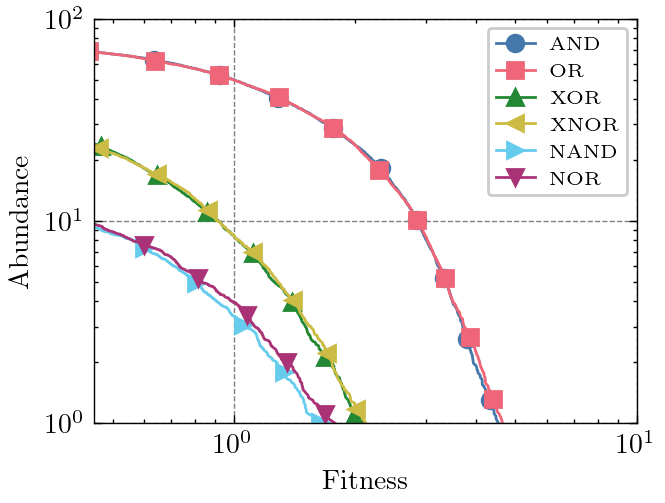

In [57]:
fig, ax = nanonets_utils.abundance_plot(abundance[7])

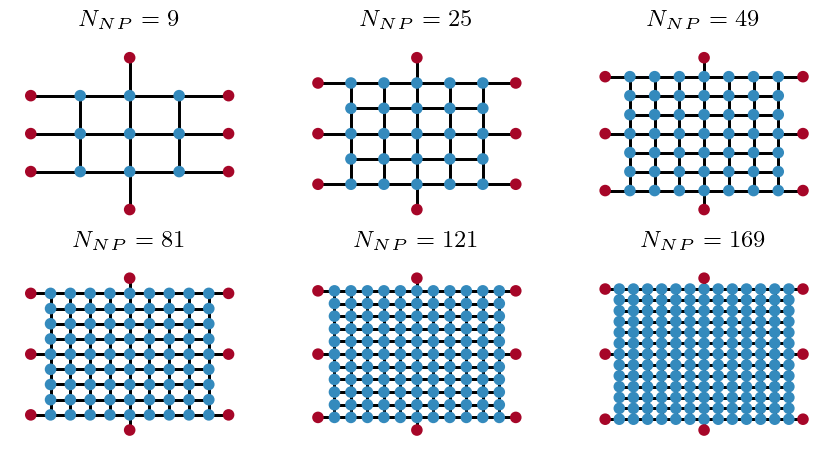

In [58]:
N_plots = [3,5,7,9,11,13]
fig     = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.)

for i, N in enumerate(N_plots):

    topology_parameter          = {
        "Nx"                :   N,
        "Ny"                :   N,
        "Nz"                :   1,
        "e_pos"             :   [[0,0,0], [int((N-1)/2),0,0], [N-1,0,0], 
                                [0,int((N-1)/2),0], [0,N-1,0], [N-1,int((N)/2),0],
                                [int((N)/2),(N-1),0], [N-1,N-1,0]],
        "electrode_type"    :   ['constant','constant','constant','constant','constant','constant','constant','constant']
    }
    sim_class   = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
    ax          = fig.add_subplot(2,3,i+1)
    fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=10, title='$N_{NP} = '+f'{N*N}$')

fig.savefig("../plots/network_sample.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/network_sample.pdf", transparent=False, bbox_inches='tight')

In [59]:
def abundance_multiplot(data: Dict, gates: List[str] = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR'], 
    dpi: int = 200, x_limits: List[float] = [0.45, 10], y_limits: List[float] = [1.0, 100], 
    xlabel: str = 'Fitness', ylabel: str = 'Abundance', n_rows=2, n_cols=3, colormap='cividis') -> Tuple[plt.Figure, plt.Axes]:

    cmap    = plt.get_cmap(colormap)
    N_vals  = len(data.keys())

    with plt.style.context(["science","bright","grid"]):
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, dpi=dpi, layout='constrained')
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.1)

        for i, gate in enumerate(gates):
            ax      = axes.flat[i]
            keys    = []
            for j, (key, df) in enumerate(data.items()):
                ax.plot(df[f'{gate} Fitness'], df[f'{gate} Fitness Abundance'], color=cmap((j)/N_vals))
                keys.append(key)
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_limits[0], y_limits[1])
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            if i >= (n_rows-1)*n_cols:
                ax.set_xlabel(xlabel)
            else:
                ax.set_xticklabels("")

            if i % n_cols == 0:
                ax.set_ylabel(ylabel)
            else:
                ax.set_yticklabels("")

            ax.set_title(gate)

        norm    = mpl.colors.Normalize(vmin=np.min(keys)**2, vmax=np.max(keys)**2)
        cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
        fig.colorbar(cbar, ax=axes.ravel(), label='$N_{NP}$')

    return fig, ax

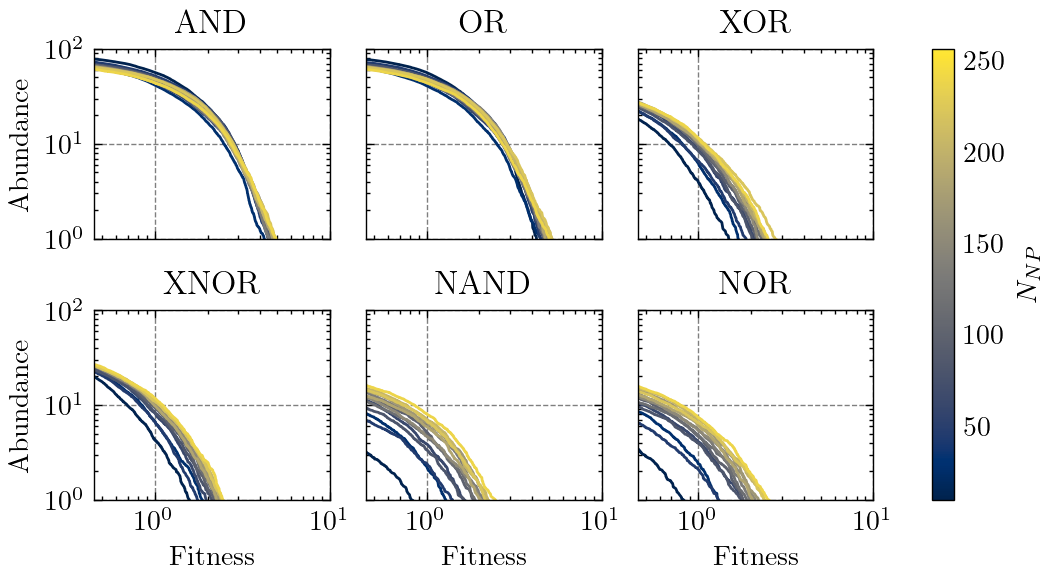

In [60]:
fig, ax = abundance_multiplot(abundance)
fig.savefig(f"../plots/abundance/gate_vs_system_size_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/abundance/gate_vs_system_size_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

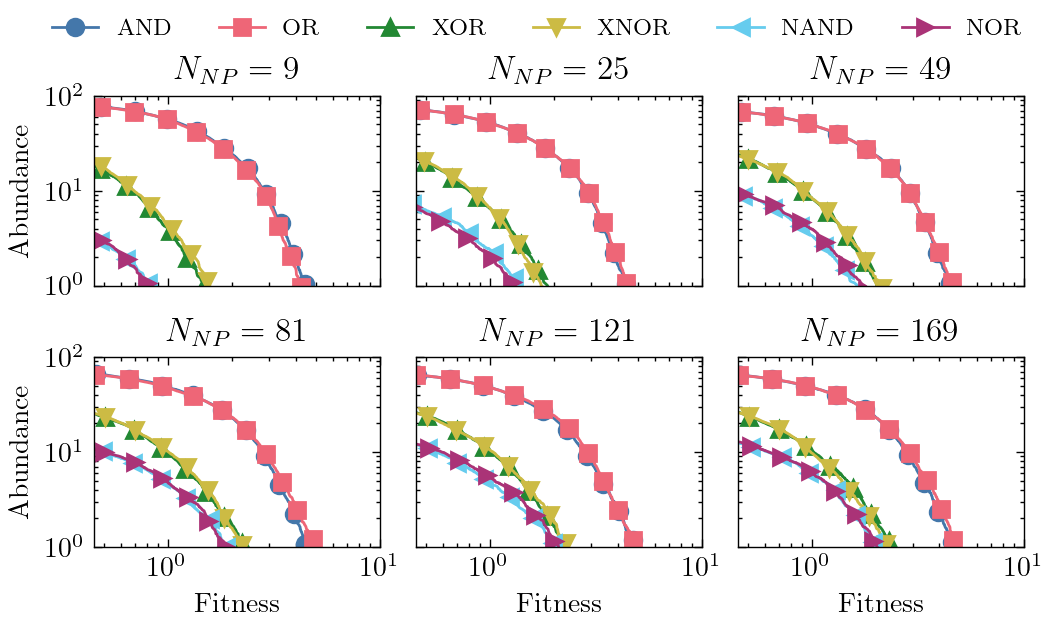

In [61]:
N_plots = [3,5,7,9,11,13]
gates   = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']
marker  = ['o','s','^','v','<','>']
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.1)

for i, N in enumerate(N_plots):

    ax  = plt.subplot(2,3,i+1)
    for j, gate in enumerate(gates):
        ax.plot(abundance[N][f'{gate} Fitness'], abundance[N][f'{gate} Fitness Abundance'], label=gate, marker=marker[j % len(marker)], markevery=0.1)
    
    ax.set_xlim(0.45, 10)
    ax.set_ylim(1.0, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('$N_{NP} = '+f'{N*N}$')
    
    if i % 3 == 0:
        ax.set_ylabel("Abundance")
    else:
        ax.set_yticklabels("")
    if i > 2:
        ax.set_xlabel("Fitness")
    else:
        ax.set_xticklabels("")
    
    if i==0:
        leg = ax.legend(loc='center', bbox_to_anchor=(1.55,1.35), ncol=6, fontsize='small')

leg.set_in_layout(False)
fig.canvas.draw()
leg.set_in_layout(True)
fig.set_layout_engine('none')
fig.savefig(f"../plots/abundance/system_size_comparison_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/abundance/system_size_comparison_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

### Nonlinear Parameter

In [3]:
# Current Relations
n_bootstrap = 1000
params      = {N : nanonets_utils.nonlinear_parameter(data[N], n_bootstrap=n_bootstrap) for i, N in enumerate(N_vals)}

# NDR / NLS
bins    = 'fd'
Q_ndr   = []
Q_nls   = []
for i in range(n_bootstrap): 

    Q_ndr_l =   np.array([nanonets_utils.return_ndr(params[N][i]['Ml']) for N in N_vals])
    Q_ndr_r =   np.array([nanonets_utils.return_ndr(params[N][i]['Mr']) for N in N_vals])
    Q_ndr.append((Q_ndr_l + Q_ndr_r) / 2)

    Q_nls.append(np.array([nanonets_utils.return_nls(df=params[N][i], bins=bins) for N in N_vals]))

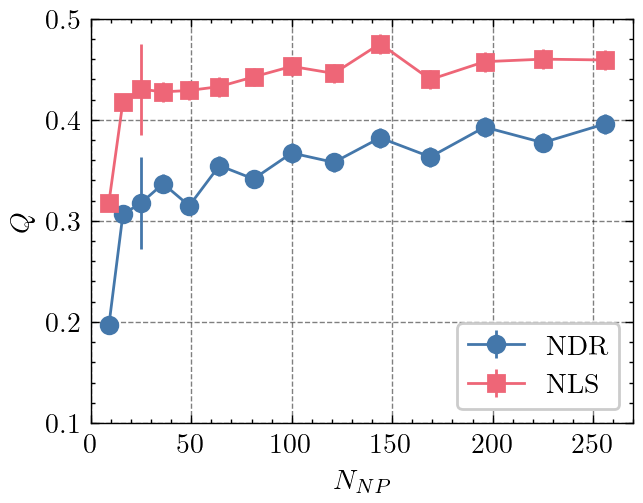

In [4]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.errorbar(np.array(N_vals)**2, np.mean(Q_ndr,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='o', label='NDR')
    ax.errorbar(np.array(N_vals)**2, np.mean(Q_nls,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='s', label='NLS')

    ax.set_xlabel('$N_{NP}$')
    ax.set_ylabel('$Q$')
    ax.legend(loc='lower right')
    ax.set_xlim(0,270)
    ax.set_ylim(0.1,0.5)

# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

In [5]:
# Current Relations
params  = {N : nanonets_utils.nonlinear_parameter(data[N]) for i, N in enumerate(N_vals)}

# NDR
Q_ndr_l = np.array([nanonets_utils.return_ndr(params[N]['Ml']) for N in N_vals])
Q_ndr_r = np.array([nanonets_utils.return_ndr(params[N]['Mr']) for N in N_vals])
Q_ndr   = (Q_ndr_l + Q_ndr_r) / 2

# NLS
bins    = 'fd'
Q_nls   = np.array([nanonets_utils.return_nls(df=params[N], bins=bins) for N in N_vals])

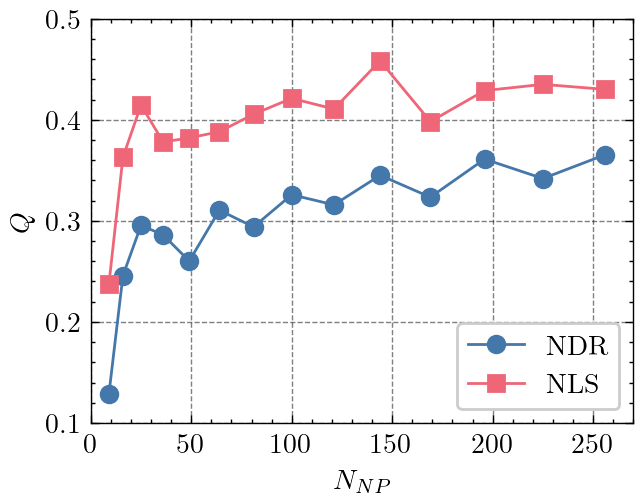

In [6]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.plot(np.array(N_vals)**2, Q_ndr, '-o', label='NDR')
    ax.plot(np.array(N_vals)**2, Q_nls, '-s', label='NLS')

    ax.set_xlabel('$N_{NP}$')
    ax.set_ylabel('$Q$')
    ax.legend(loc='lower right')
    ax.set_xlim(0,270)
    ax.set_ylim(0.1,0.5)

fig.savefig("../plots/nonlinearity_vs_system_size.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/nonlinearity_vs_system_size.pdf", transparent=False, bbox_inches='tight')

### Best Gates

In [64]:
N       = 11
gate    = 'XOR'
best_g  = nanonets_utils.get_best_logic_gate(data[N], fitness[N], gate)
best_g

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Current,Error
0,-0.042685,0.00,-0.038521,0.00,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,165000.0,96.498867,4.491121
1,-0.042685,0.00,-0.038521,0.01,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,225000.0,103.607082,4.749572
2,-0.042685,0.01,-0.038521,0.00,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,205000.0,103.538315,4.681723
3,-0.042685,0.01,-0.038521,0.01,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,115000.0,95.936037,3.951228


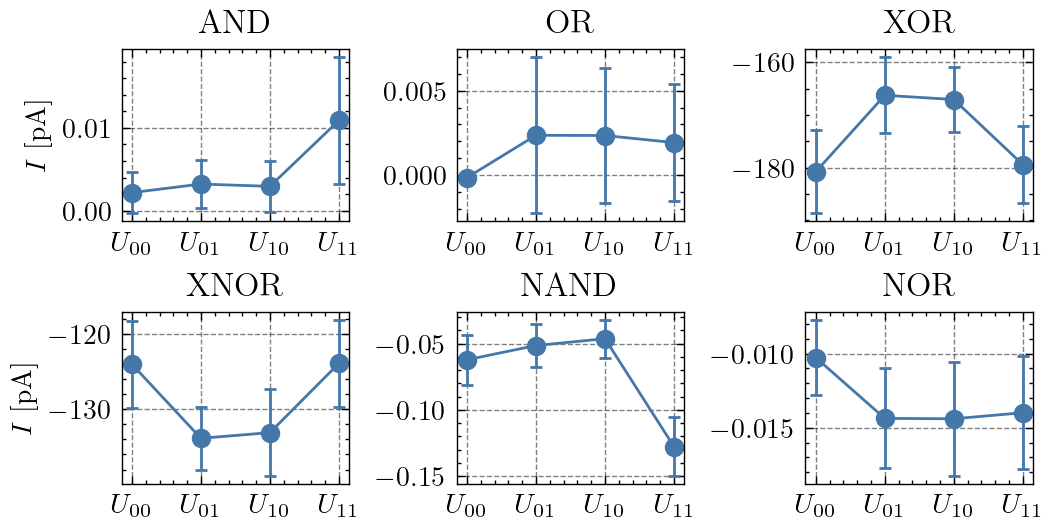

In [65]:
N = 15

with plt.style.context(["science","bright","grid"]):
    
    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*1)

    for i, gate in enumerate(['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']):

        best_g  = nanonets_utils.get_best_logic_gate(data[N], fitness[N], gate)
        ax      = fig.add_subplot(2,3,i+1)
        ax.errorbar(["$U_{00}$","$U_{01}$","$U_{10}$","$U_{11}$"], best_g['Current'], best_g['Error'], marker='o', capsize=2)
        ax.set_title(gate)

        if i % 3 == 0:
            ax.set_ylabel("$I$ [pA]")

fig.savefig(f"../plots/best_gates_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/best_gates_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

In [66]:
max_jumps_portion   = [100*((data[N]['Jumps']==1e7).sum() / len(data[N])) for N in N_vals]
rel_error_dist      = [100*np.abs(data[N]['Error'].values / data[N]['Current'].values) for N in N_vals]

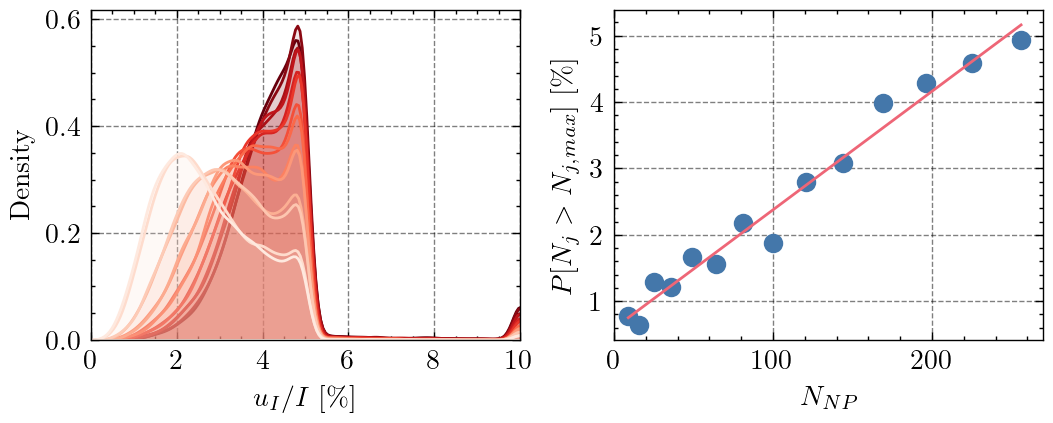

In [67]:
def lin_func(x, a, b):
    return a*x + b

with plt.style.context(["science","bright","grid"]):

    cmap    = plt.get_cmap('Reds')
    fig     = plt.figure(dpi=200, layout='constrained')
    ax1     = fig.add_subplot(1,2,1)
    ax2     = fig.add_subplot(1,2,2)
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*0.8)

    for i, arr in enumerate(rel_error_dist[::-1]):
        arr[arr>10] = 10
        ax1         = sns.kdeplot(arr, ax=ax1, color=cmap((len(rel_error_dist)-i)/len(rel_error_dist)), fill=True, alpha=0.1)

    ax1.set_xlim(0,10)
    ax1.set_xlabel('$u_I / I$ [\%]')

    x       = np.array(N_vals)**2
    y       = max_jumps_portion
    p, _    = curve_fit(lin_func, x, y)
    ax2.plot(x, y, 'o')
    ax2.plot(x, lin_func(x,*p), '-')
    ax2.set_xlabel('$N_{NP}$')
    ax2.set_ylabel('$P[N_{j} > N_{j,max}]$ [\%]')
    ax2.set_xlim(0,270)

    fig.savefig("../plots/data_quality_vs_system_size.svg", transparent=True, bbox_inches='tight')
    fig.savefig("../plots/data_quality_vs_system_size.pdf", transparent=False, bbox_inches='tight')